In [1]:
import sys, os
import rasterio, geopandas, shapely
import pandas, numpy
from scipy import interpolate
import warnings
#import multiprocess as mp
#import time

shapely.speedups.enable()
warnings.simplefilter('error', RuntimeWarning) 

# set resolution level
dggs_res = 19

## construct a look-up table, storing resolution and corresponding cell size and vertical resolution
res_list = [16,17,18,19,20,21,22,23,24,25,26,27,28,29]
cell_size_list = [0.005,0.003,0.001,0.0009,0.0008,0.0006,0.0003,0.0002,0.0001,0.00006,0.00003,0.00002,0.00001,0.000005]
vertical_res_list = [0,0,0,1,1,2,2,3,3,4,4,5,5,6]
# convert to a pandas dataframe with resolution levels as index
look_up = pandas.DataFrame({'res': res_list, 'cell_size': cell_size_list, 'verti_res': vertical_res_list}, index = res_list)

print(look_up)

# look up cellsize and vertical resolution
dggs_cellsize = look_up.loc[dggs_res,'cell_size']
vertical_res = look_up.loc[dggs_res,'verti_res']

    res  cell_size  verti_res
16   16   0.005000          0
17   17   0.005000          0
18   18   0.003000          0
19   19   0.001000          1
20   20   0.000800          1
21   21   0.000600          2
22   22   0.000300          2
23   23   0.000200          3
24   24   0.000100          3
25   25   0.000070          4
26   26   0.000030          4
27   27   0.000020          5
28   28   0.000010          5
29   29   0.000005          6


In [2]:
## read the csv into a dataframe
input_csv_path = 'Result/centroids.csv'
centroid_df = pandas.read_csv(input_csv_path, sep=',', usecols=['Cell_address', 'lon_c', 'lat_c'])

## Prepare HRDEM_extent polygons
HRDEM_extent = geopandas.GeoDataFrame.from_file('Data/Projects_Footprints_dissolved.shp')
HRDEM_extent = HRDEM_extent.to_crs("EPSG:4617") # NAD83 CSRS

## Read DEMs -- CDEM + HRDEM
CDEM_TIF = rasterio.open('Data/CDEM_cgvd2013.tif')
CDEM_pixelSizeX = abs(CDEM_TIF.transform[0])
CDEM_pixelSizeY = abs(CDEM_TIF.transform[4])

HRDEM_TIF = rasterio.open('Data/HRDEM_cgvd2013.tif')
HRDEM_pixelSizeX = abs(HRDEM_TIF.transform[0])
HRDEM_pixelSizeY = abs(HRDEM_TIF.transform[4])

In [3]:
## Define the main funcitons    
def find_neighbor(x,y,dataset):
    ''' 
    Find neighbors for interpolation --
    determine the DEM source
    find out the 9 neighbors geographic coords
    extract the elevations at these 9 coords
    convert 9 coords to array index then back to 9 coords of grid mesh centers
    '''
    if dataset == 'HRDEM':
        pixelSizeX, pixelSizeY = HRDEM_pixelSizeX,HRDEM_pixelSizeY
        DEM_TIF= HRDEM_TIF
    elif dataset == 'CDEM':
        pixelSizeX, pixelSizeY = CDEM_pixelSizeX,CDEM_pixelSizeY
        DEM_TIF = CDEM_TIF  
    x_coord,y_coord = [x-pixelSizeX,x,x+pixelSizeX],[y-pixelSizeY,y,y+pixelSizeY]
    x_coord,y_coord = numpy.repeat(x_coord,3),numpy.array(y_coord*3)
    coords = [(lon,lat) for lon, lat in zip(x_coord,y_coord)]
    z_array = [elev[0] for elev in DEM_TIF.sample(coords)]
    x_index,y_index = rasterio.transform.rowcol(DEM_TIF.transform, x_coord, y_coord)
    x_array,y_array = rasterio.transform.xy(DEM_TIF.transform, x_index, y_index)
    return x_array, y_array, z_array

def dggs_elevation_cdem(x,y,interp = 'linear'):
    ''' 
    Resample CDEM -- 
    if an error is raised then return -32767 as its final elevation
    if the point or any of its neighbors has the value -32767 then return -32767 as its final elevation
    if none of its neighbor has value -32767 then interpolate elevation
    restrict the decimal places according to the look-up table defined earlier 
    '''
    dataset = 'CDEM'
    try:
        x_array, y_array, z_array = find_neighbor(x,y,dataset)
        if -32767 in z_array:
            return -32767
        else:
            CDEM_interp = interpolate.interp2d(x_array, y_array, z_array, kind=interp)
            elevation = CDEM_interp(x,y)[0]
            elevation = round(elevation,vertical_res)
            return elevation
    except:
        return -32767

def dggs_elevation_hrdem(x,y,interp = 'linear'):
    ''' 
    Resample HRDEM -- 
    if the point falls in the HRDEM data extend then proceed
    if the point or any of its neighbors has the value -32767 then pass
    if an error is raised then pass
    restrict the decimal places according to the look-up table defined earlier 
    '''
    dataset = 'HRDEM'
    point = shapely.geometry.Point(x,y)
    if point.within(HRDEM_extent.geometry[0]):
        try:
            x_array, y_array, z_array = find_neighbor(x,y,dataset)
            if -32767 in z_array:
                pass
            else:
                HRDEM_interp = interpolate.interp2d(x_array, y_array, z_array, kind=interp)
                elevation = HRDEM_interp(x,y)[0]
                elevation = round(elevation,vertical_res)
                return elevation
        except:
            pass
    else:
        pass
    
def dggs_elevation_df(dataframe):
    ''' a function on the dataframe '''
    dataframe['model_cdem'] = [dggs_elevation_cdem(lon,lat) for lon, lat in zip(dataframe.lon_c, dataframe.lat_c)]
    dataframe['model_hrdem'] = [dggs_elevation_hrdem(lon,lat) for lon, lat in zip(dataframe.lon_c, dataframe.lat_c)]
    return dataframe

In [4]:
# call functions
centroid_df_output = dggs_elevation_df(centroid_df)
centroid_df_output.head(200)

,Cell_address,lon_c,lat_c,model_cdem,model_hrdem
0,5002019930,-78.348646,44.774979,-32767.0,NaN
1,5001980564,-78.346305,44.776069,332.8,336.5
2,5001960881,-78.344033,44.774992,-32767.0,NaN
3,5001921515,-78.341691,44.776083,351.7,349.5
4,5001941199,-78.341761,44.773915,-32767.0,NaN
...,...,...,...,...,...
195,5000976729,-78.272275,44.782767,341.1,346.1
196,5000917680,-78.267662,44.782777,355.7,362.1
197,5000858631,-78.263049,44.782788,346.9,349.9
198,5000799582,-78.258435,44.782798,331.4,332.6


In [5]:
# save the results as csv
output_csv_path = 'Result/results.csv'
centroid_df_output = centroid_df_output.drop(columns=['lon_c','lat_c'])
centroid_df_output.to_csv(output_csv_path, index=False)

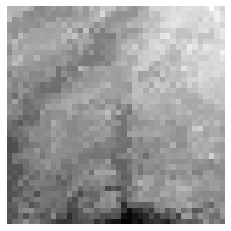

In [6]:
# visualization -- by datashader
import datashader as ds, matplotlib.pyplot as plt, pandas as pd
import sys, numpy, gc, matplotlib
from datashader.mpl_ext import dsshow
%matplotlib inline

centroid_df = pd.read_csv('Result/centroids.csv')
elev_df = pd.read_csv('Result/results.csv')

merge_df = pd.merge(left = elev_df, right = centroid_df, how="inner", on="Cell_address")
merge_df['model_elev'] = numpy.where(numpy.isnan(merge_df['model_hrdem']), merge_df['model_cdem'], merge_df['model_hrdem'])
merge_df = merge_df[merge_df['model_elev']!=-32767]

fig, ax = plt.subplots()
artist = dsshow(merge_df, ds.Point('lon_c', 'lat_c'), aggregator = ds.mean('model_elev'), cmap = 'gray', 
                plot_width=40, plot_height=40, ax = ax)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.axis("off")

plt.show()

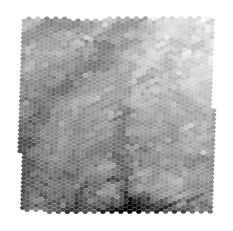

In [8]:
# visualization -- by plotting hexagonal grids
import matplotlib.pyplot as plt
import gc, matplotlib, pandas, geopandas, numpy
%matplotlib inline

# read polygon shapefile and elevation csv
polygons = geopandas.GeoDataFrame.from_file('Result/hexagon_grids.shp')
polygons = polygons.rename(columns={"dummy":"Cell_address"})
polygons.Cell_address.astype(int)
elev_df = pd.read_csv('Result/results.csv')

# join dataframes on common cell address
merge_df = pandas.merge(left = polygons, right = elev_df, how="left", on="Cell_address")
merge_df['model_elev'] = numpy.where(numpy.isnan(merge_df['model_hrdem']), merge_df['model_cdem'], merge_df['model_hrdem'])
merge_df = merge_df.drop(columns=['model_cdem','model_hrdem'])
merge_df = merge_df[merge_df['model_elev']!=-32767]

del polygons,elev_df
gc.collect()

# plot the joined dataframe
fig, ax = plt.subplots()
merge_df.plot(column='model_elev', ax=ax, cmap='gray', legend=None, figsize=(800, 800), edgecolor='None')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
ax.axis("off")

plt.show()